Found 1556 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Found 836 images belonging to 2 classes.
Class indices: {'image': 0, 'mask': 1}
Class distribution in training set: [778 778]
Class distribution in validation set: [277 277]
Class distribution in test set: [418 418]
Epoch 1/10
98/98 [==============================] - 255s 3s/step - loss: 1.4036 - accuracy: 0.9531 - val_loss: 5.1645e-07 - val_accuracy: 1.0000
Epoch 2/10
98/98 [==============================] - 258s 3s/step - loss: 0.6208 - accuracy: 0.9871 - val_loss: 6.5943e-07 - val_accuracy: 1.0000
Epoch 3/10
98/98 [==============================] - 253s 3s/step - loss: 0.1466 - accuracy: 0.9955 - val_loss: 1.6926e-06 - val_accuracy: 1.0000
Epoch 4/10
98/98 [==============================] - 258s 3s/step - loss: 0.1228 - accuracy: 0.9929 - val_loss: 4.7764e-07 - val_accuracy: 1.0000
Epoch 5/10
98/98 [==============================] - 244s 2s/step - loss: 0.2895 - accuracy: 0.9942 - val_loss: 9.0678e-07

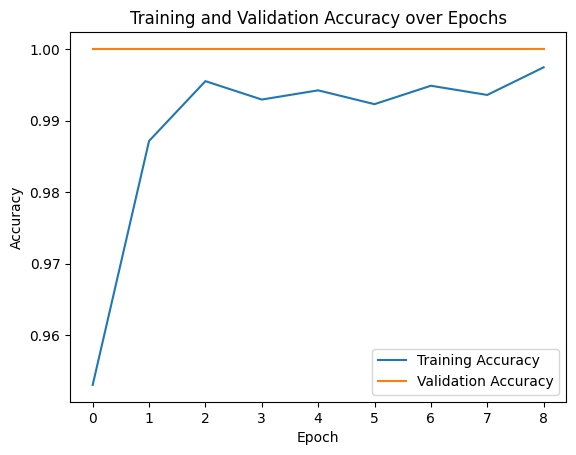

53/53 [==============================] - 14s 264ms/step
Test Accuracy: 0.9964114832535885
Test Precision: 0.9928741092636579
Test AUC: 1.0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, auc

# Directory paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/PROMISE12/train_data'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/PROMISE12/validation_data'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/PROMISE12/test_data'

# Image dimensions
img_height = 256
img_width = 256
batch_size = 16

# Data augmentation for training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                       target_size=(img_height, img_width),
                                                                       batch_size=batch_size,
                                                                       class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                        target_size=(img_height, img_width),
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)

# Verify the class indices
print("Class indices:", train_generator.class_indices)

# Check class imbalance
print("Class distribution in training set:", np.bincount(train_generator.classes))
print("Class distribution in validation set:", np.bincount(val_generator.classes))
print("Class distribution in test set:", np.bincount(test_generator.classes))

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define MLP model using Sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping])

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Evaluate the model
test_pred = model.predict(test_generator)
test_labels = test_generator.classes
test_accuracy = accuracy_score(test_labels, np.round(test_pred))
test_precision = precision_score(test_labels, np.round(test_pred))
test_auc = roc_auc_score(test_labels, test_pred)
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
test_roc_auc = auc(fpr, tpr)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test AUC: {test_auc}')
